In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from ASHRAE_tools import meter_dict
from zipfile import ZipFile
from pandas.plotting import scatter_matrix

meter_dict = meter_dict()

## Load Data

In [2]:
if not os.path.exists('data'):
    os.makedirs('data')


In [3]:
#! kaggle competitions download -c ashrae-energy-prediction -p ./data

In [4]:
#zf = ZipFile("./data/ashrae-energy-prediction.zip")
#zf.extractall(path = './data')
#zf.close()

## EDA Train Data

In [5]:
train = pd.read_csv('./data/train.csv')
building_metadata = pd.read_csv('./data/building_metadata.csv')

In [6]:
train.shape

(20216100, 4)

In [7]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [8]:
train.dtypes

building_id        int64
meter              int64
timestamp         object
meter_reading    float64
dtype: object

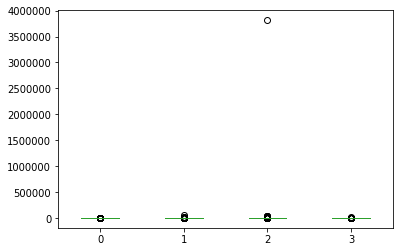

In [9]:
train.pivot_table(values='meter_reading',index='building_id',columns='meter',aggfunc=np.mean).plot.box()
plt.show()

En la gráfica de arriba se ve un punto atípico. Eliminaremos todas las medidas mayores a *1,000,000kWh*

In [10]:
train.loc[(train['meter_reading']>100000)].groupby('building_id').count()

,meter,timestamp,meter_reading
building_id,,,
60,1,1,1
778,837,837,837
954,1,1,1
993,1,1,1
1021,52,52,52
1088,311,311,311
1099,3265,3265,3265
1159,2,2,2
1168,552,552,552


In [11]:
building_metadata.loc[building_metadata['building_id']==1099]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1099,13,1099,Education,332884,NaN,NaN


In [13]:
train.loc[(train['meter_reading']>100000),'meter_reading'] = -1

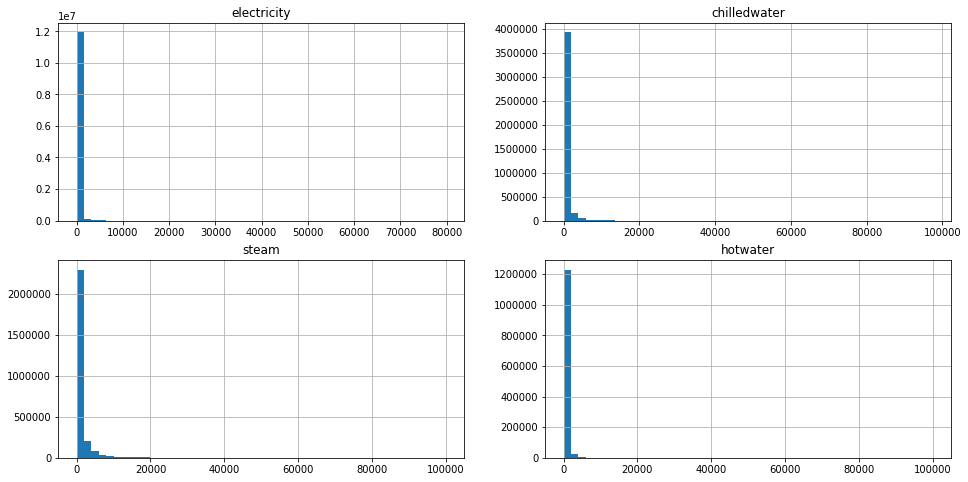

In [14]:
#plt.rcParams["figure.figsize"] = (16,8)

plt.subplot(221)
train.loc[train['meter']==0].meter_reading.hist(bins=50, figsize = (16,8))
plt.title(meter_dict[0])
plt.grid(True)

plt.subplot(222)
train.loc[train['meter']==1].meter_reading.hist(bins=50, figsize = (16,8))
plt.title(meter_dict[1])

plt.subplot(223)
train.loc[train['meter']==2].meter_reading.hist(bins=50, figsize = (16,8))
plt.title(meter_dict[2])

plt.subplot(224)
train.loc[train['meter']==3].meter_reading.hist(bins=50, figsize = (16,8))
plt.title(meter_dict[3])

plt.show()

In [15]:
train.groupby('meter').size()

meter
0    12060910
1     4182440
2     2708713
3     1264037
dtype: int64

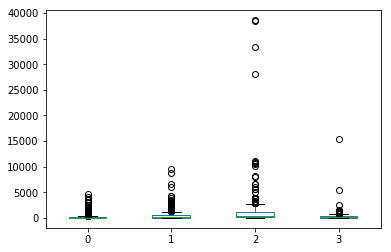

In [16]:
train.pivot_table(values='meter_reading',index='building_id',columns='meter',aggfunc=np.mean).plot.box()
plt.show()

## Analiza weather data

In [17]:
weather_train = pd.read_csv('./data/weather_train.csv')

In [18]:
weather_train.shape

(139773, 9)

In [19]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


## EDA Metadata

In [21]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [127]:
building_metadata.describe()
#building_metadata.groupby('primary_use').size()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


La tabla metadata tiene una observación por cada *building*

## Tidy train data

In [24]:
tidy_train = train.join(building_metadata, on = 'building_id', lsuffix = '_', rsuffix = '_meta')
tidy_train.drop('building_id_meta', inplace=True, axis=1)

In [26]:
tidy_train = tidy_train.merge(weather_train, on = ['site_id','timestamp'], how='left')
tidy_train['timestamp'] = pd.to_datetime(tidy_train['timestamp'])

In [27]:
tidy_train.head()

,building_id_,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [50]:
tidy_train.dtypes

building_id_                   int64
meter                          int64
timestamp             datetime64[ns]
meter_reading                float64
site_id                        int64
primary_use                   object
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
cloud_coverage               float64
dew_temperature              float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
dtype: object

In [49]:
tidy_train.describe()

,building_id_,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,7.992780e+02,6.624412e-01,4.298946e+02,7.992232e+00,1.077830e+05,1.968277e+03,4.184848e+00,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00
std,4.269133e+02,9.309921e-01,2.088924e+03,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00
min,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,8.950000e+02,0.000000e+00,7.865500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.179000e+03,1.000000e+00,2.674800e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,3.000000e+00,9.998440e+04,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


## EDA Total

### Timestamp

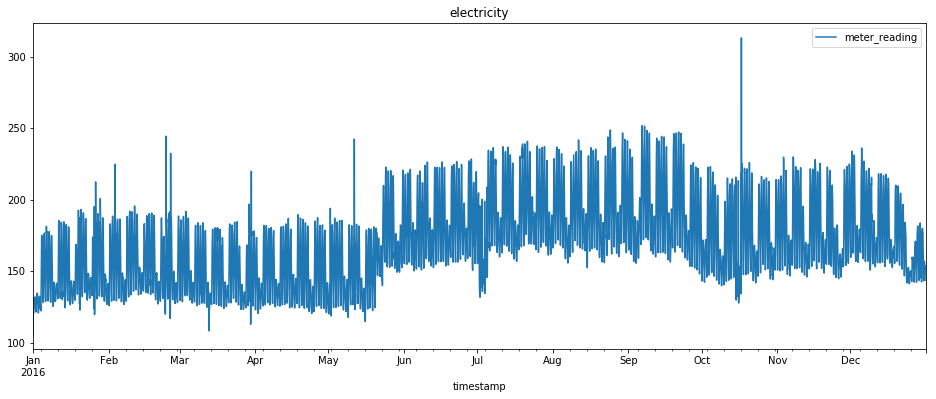

In [28]:
tidy_train.loc[tidy_train['meter']==0,['timestamp','meter_reading']].groupby('timestamp').mean().plot(figsize = (16,6))
plt.title(meter_dict[0])

Text(0.5, 1.0, 'chilledwater')

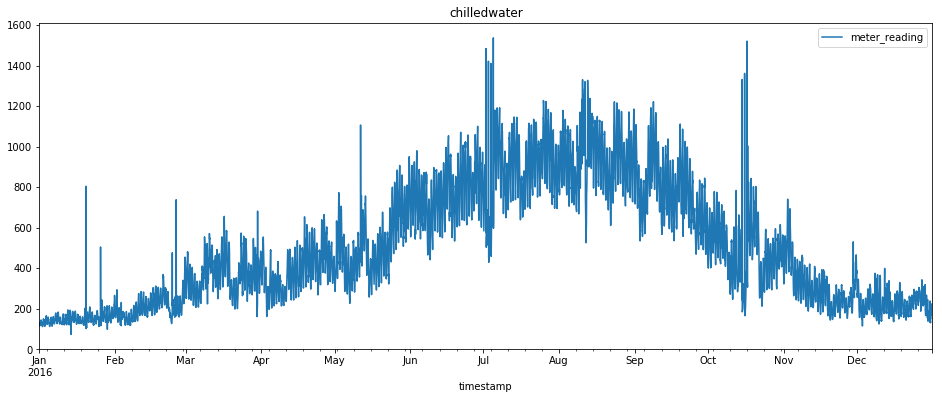

In [29]:
tidy_train.loc[tidy_train['meter']==1,['timestamp','meter_reading']].groupby('timestamp').mean().plot(figsize = (16,6))
plt.title(meter_dict[1])
#plt.show()

Text(0.5, 1.0, 'steam')

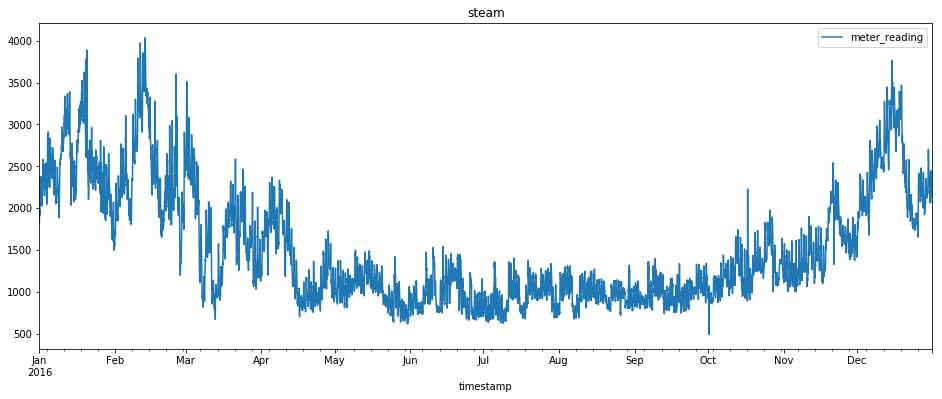

In [30]:
tidy_train.loc[tidy_train['meter']==2,['timestamp','meter_reading']].groupby('timestamp').mean().plot(figsize = (16,6))
plt.title(meter_dict[2])
#plt.show()

Text(0.5, 1.0, 'hotwater')

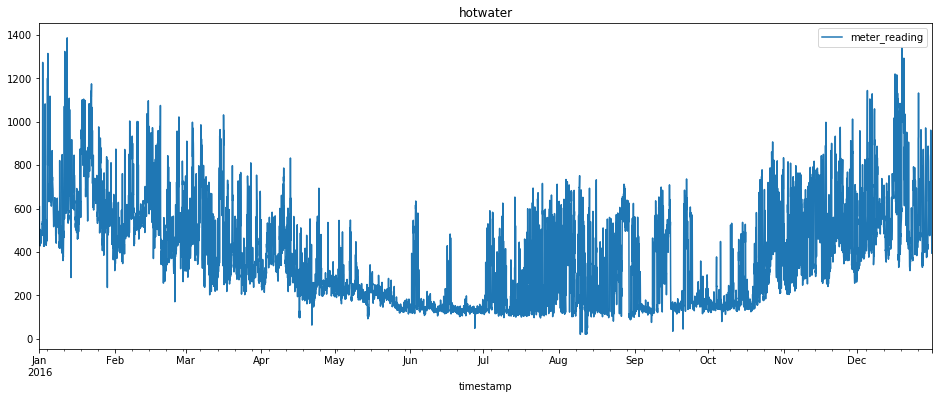

In [31]:
tidy_train.loc[tidy_train['meter']==3,['timestamp','meter_reading']].groupby('timestamp').mean().plot(figsize = (16,6))
plt.title(meter_dict[3])


Claramente el consumo de energía tiene un comportamiento muy ligado al tiempo, lo que incluye, hora, día de la semana y mes. Por tal razón, puede aportar bastante incluir variables independientes para estos aspectos del tiempo.

In [55]:
tidy_train['hour'] = tidy_train.timestamp.dt.hour

In [88]:
tidy_train['day'] = tidy_train.timestamp.dt.normalize()

In [80]:
tidy_train['wday'] = tidy_train.timestamp.dt.dayofweek

In [68]:
tidy_train['week'] = tidy_train.timestamp.dt.weekofyear

In [91]:
tidy_train.dtypes

building_id_                   int64
meter                          int64
timestamp             datetime64[ns]
meter_reading                float64
site_id                        int64
primary_use                   object
square_feet                    int64
year_built                   float64
floor_count                  float64
air_temperature              float64
cloud_coverage               float64
dew_temperature              float64
precip_depth_1_hr            float64
sea_level_pressure           float64
wind_direction               float64
wind_speed                   float64
hour                           int64
day                   datetime64[ns]
week                           int64
wday                           int64
dtype: object

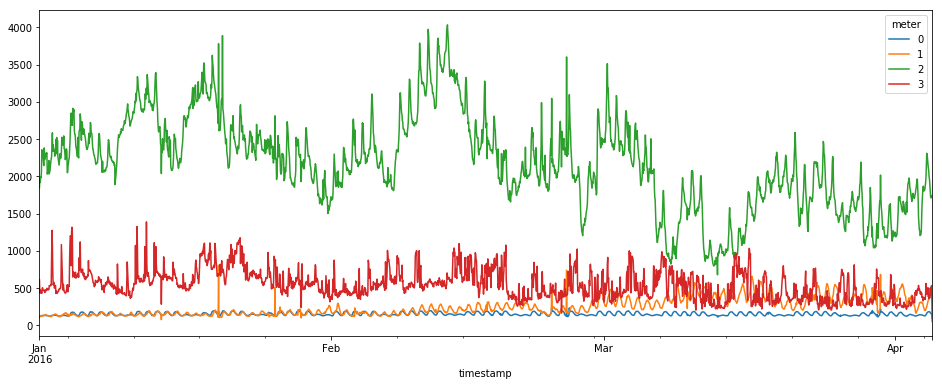

In [102]:
tidy_train.loc[1:5000000,['timestamp','meter','meter_reading']].pivot_table(values='meter_reading',index='timestamp',columns='meter',aggfunc=np.mean).plot(figsize = (16,6))

### Site

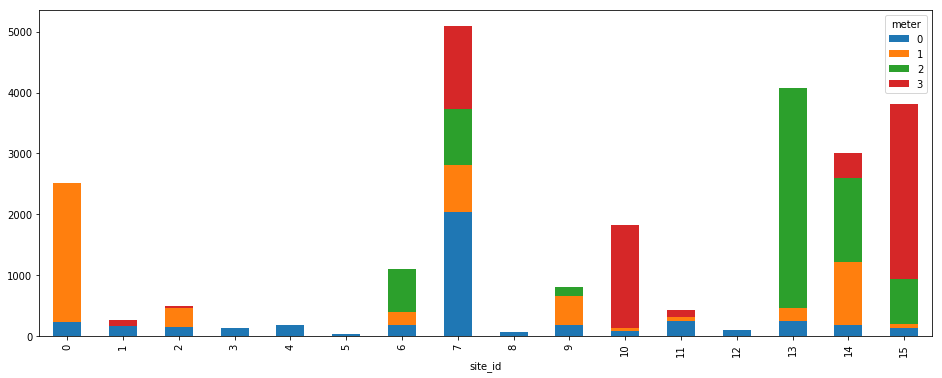

In [33]:
tidy_train.loc[:,['meter','site_id','meter_reading']].pivot_table(values='meter_reading',index='site_id',columns='meter',aggfunc=np.mean).plot.bar(stacked=True,figsize = (16,6))
plt.show()

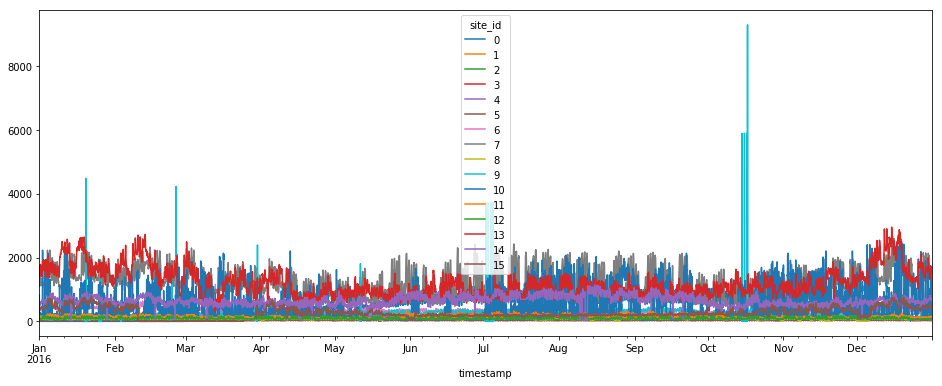

In [97]:
tidy_train.loc[:,['timestamp','site_id','meter_reading']].pivot_table(values='meter_reading',index='timestamp',columns='site_id',aggfunc=np.mean).plot(figsize = (16,6))

El sitio que más concentra consumo electrico es el 13, y de este, la mayoría es del tipo *steam*. Esta parece ser una variable que aporta información para el modelo.

### Primary Use

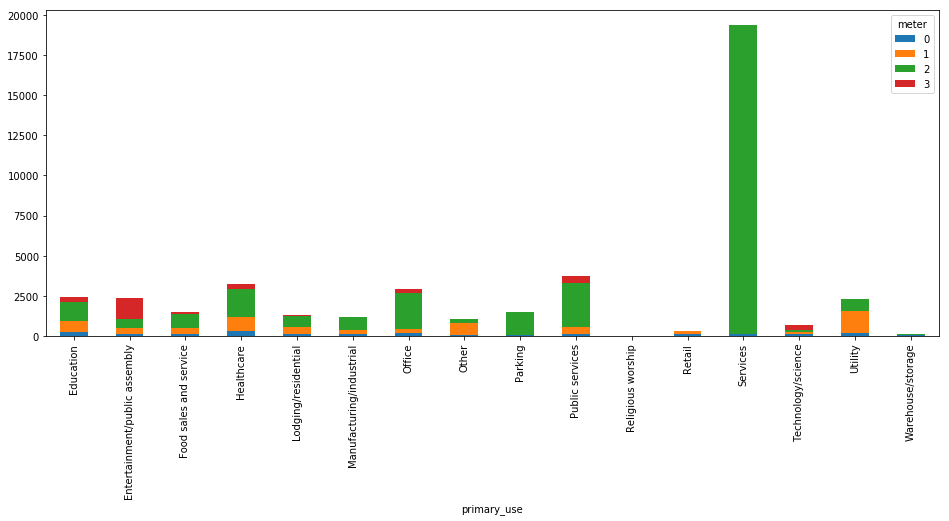

In [34]:
tidy_train.loc[:,['meter','primary_use','meter_reading']].pivot_table(values='meter_reading',index='primary_use',columns='meter',aggfunc=np.mean).plot.bar(stacked=True,figsize = (16,6))
plt.show()

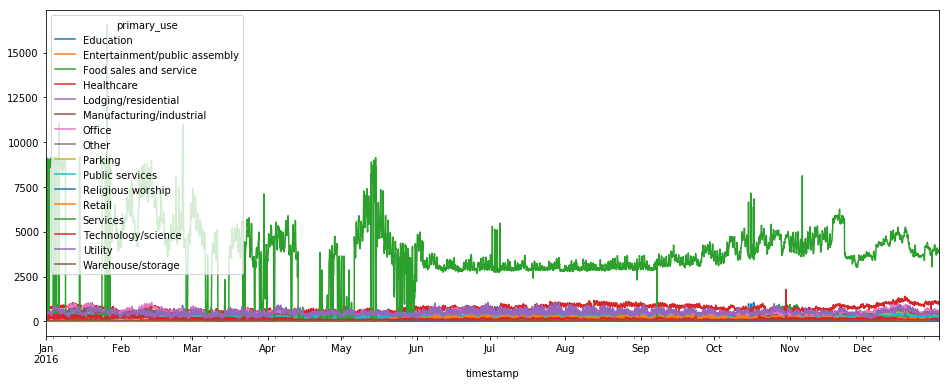

In [103]:
tidy_train.loc[:,['timestamp','primary_use','meter_reading']].pivot_table(values='meter_reading',index='timestamp',columns='primary_use',aggfunc=np.mean).plot(figsize = (16,6))

### Square feet

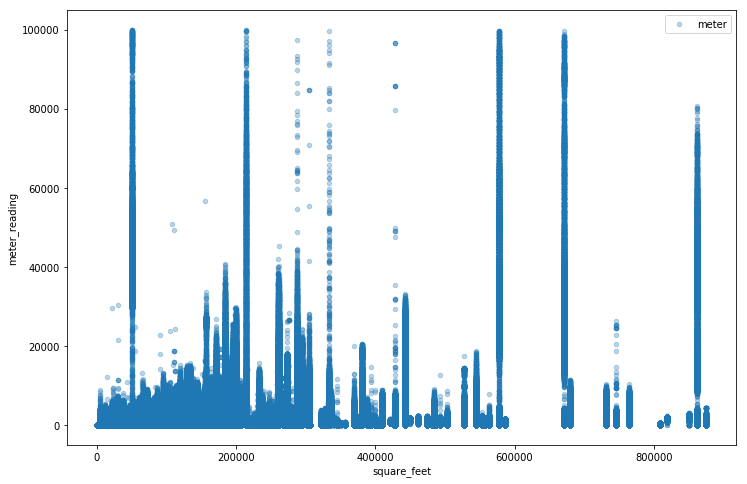

In [106]:
    tidy_train.loc[:,['square_feet','meter_reading','meter']].plot.scatter(x = 'square_feet', y = 'meter_reading', label = 'meter',figsize = (12,8), alpha=0.3)

Esta gráfica no nos dice mucha información, así que la agruparemos por dia

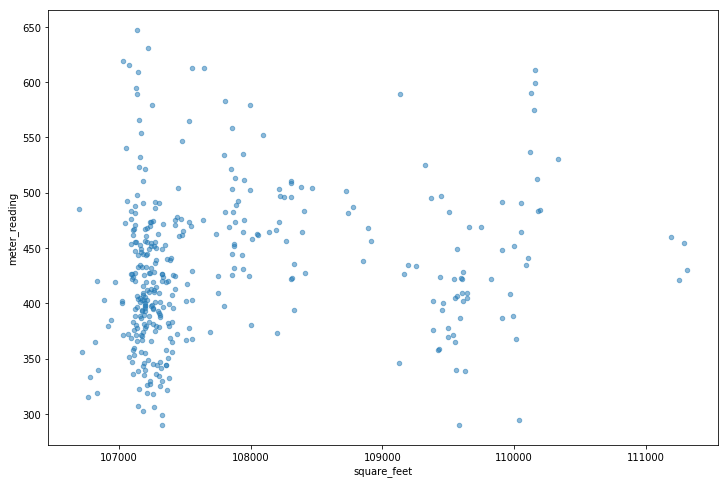

In [112]:
tidy_train.groupby('day').mean().plot.scatter(x = 'square_feet', y = 'meter_reading', figsize = (12,8), alpha=0.5)

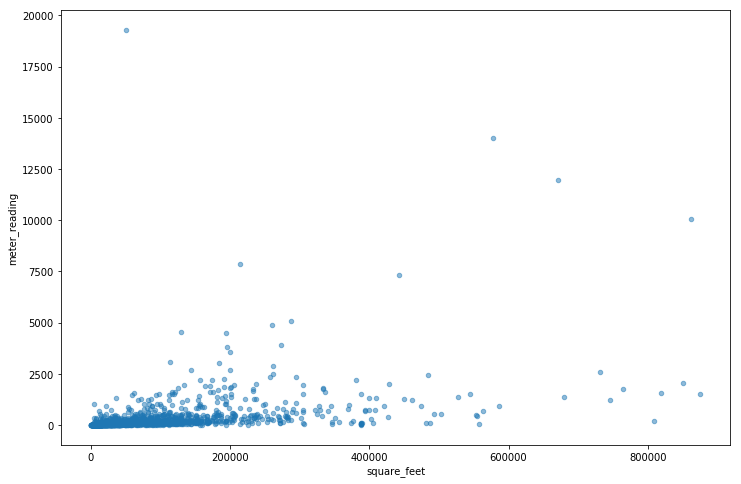

In [129]:
tidy_train.groupby('building_id_').mean().plot.scatter(x = 'square_feet', y = 'meter_reading', figsize = (12,8), alpha=0.5)

In [126]:
sum(tidy_train['cloud_coverage']!= 'NaN')

20216100

### Year built

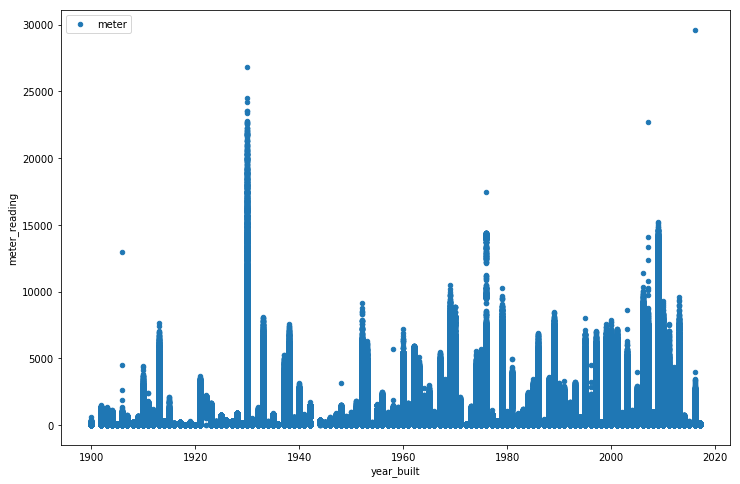

In [36]:
tidy_train.loc[:,['year_built','meter_reading','meter']].plot.scatter(x = 'year_built', y = 'meter_reading', label = 'meter',figsize = (12,8))

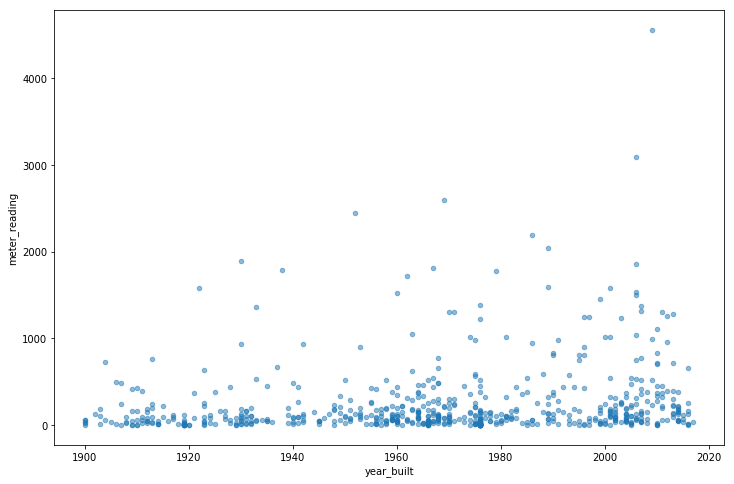

In [130]:
tidy_train.groupby('building_id_').mean().plot.scatter(x = 'year_built', y = 'meter_reading', figsize = (12,8), alpha=0.5)

El año de construcción parece dar cierta información de los datos

### Floor count

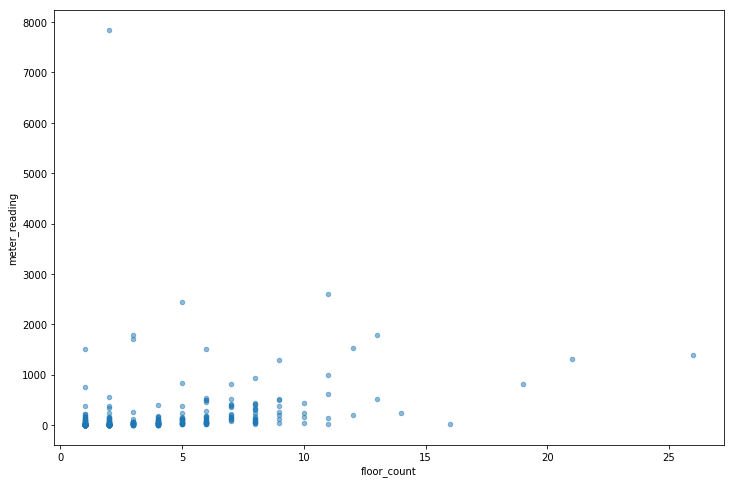

In [131]:
tidy_train.groupby('building_id_').mean().plot.scatter(x = 'floor_count', y = 'meter_reading', figsize = (12,8), alpha=0.5)

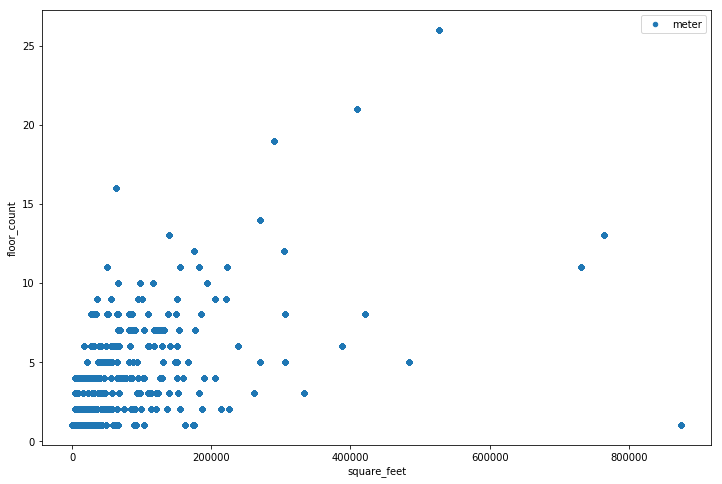

In [37]:
tidy_train.loc[:,['square_feet','floor_count','meter']].plot.scatter(x = 'square_feet', y = 'floor_count', label = 'meter',figsize = (12,8))

Aunque los pisos puden dar información, hay muchos datos faltantes y mucha de la información se cubre con los pies cuadrados. Tal vez sea conveniente elminar esta variable

In [132]:
tidy_train.drop('floor_count', inplace=True, axis=1)

### Air temperature

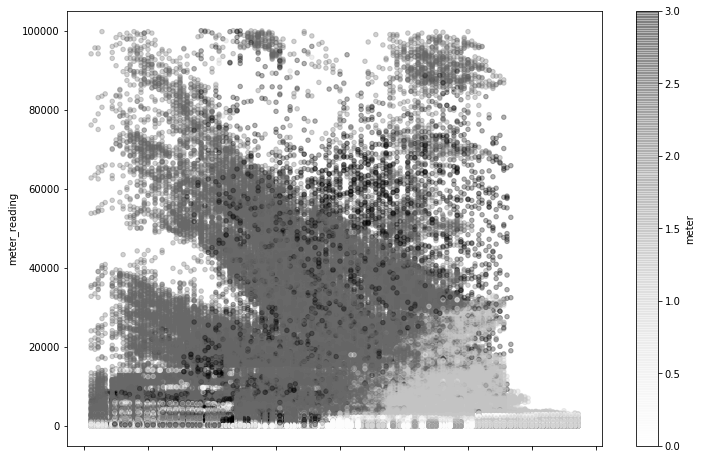

In [40]:
tidy_train.loc[:,['air_temperature','meter_reading','meter']].plot.scatter(x = 'air_temperature', y = 'meter_reading', c = 'meter',figsize = (12,8), alpha = 0.3)

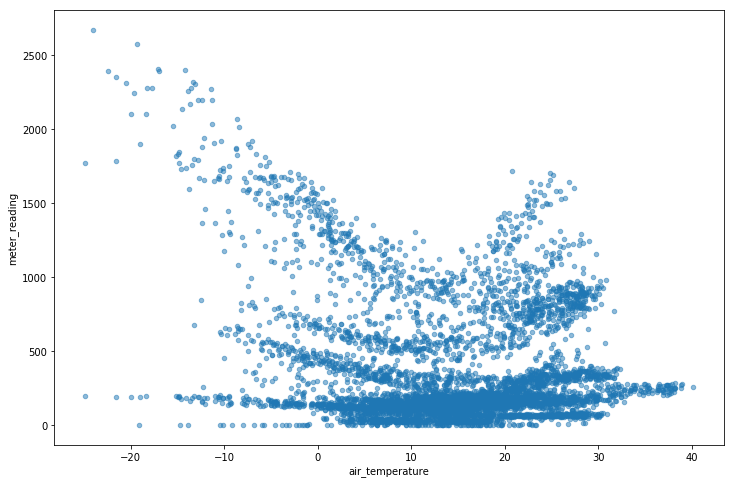

In [158]:
tidy_train.groupby(['day','site_id']).mean().plot.scatter(x = 'air_temperature', y = 'meter_reading', figsize = (12,8), alpha=0.5)

Esta variable parace tener una relación cuadrática con respecto a la variable dependiente

### Cloud coverage

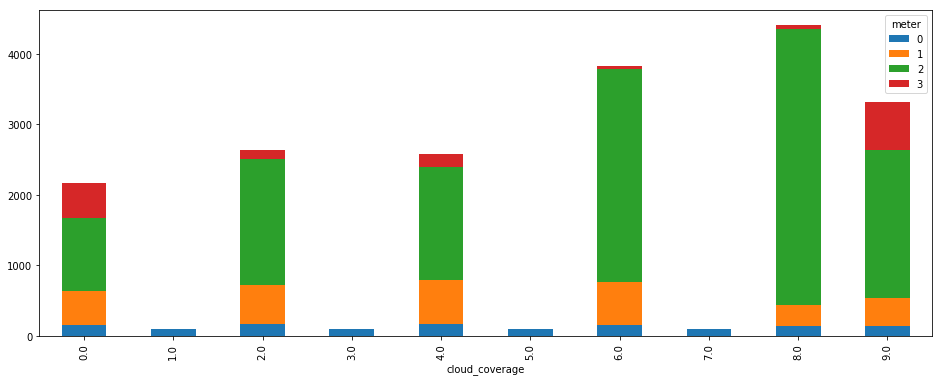

In [137]:
tidy_train.loc[:,['meter','cloud_coverage','meter_reading']].pivot_table(values='meter_reading',index='cloud_coverage',columns='meter',aggfunc=np.mean).plot.bar(stacked=True,figsize = (16,6))

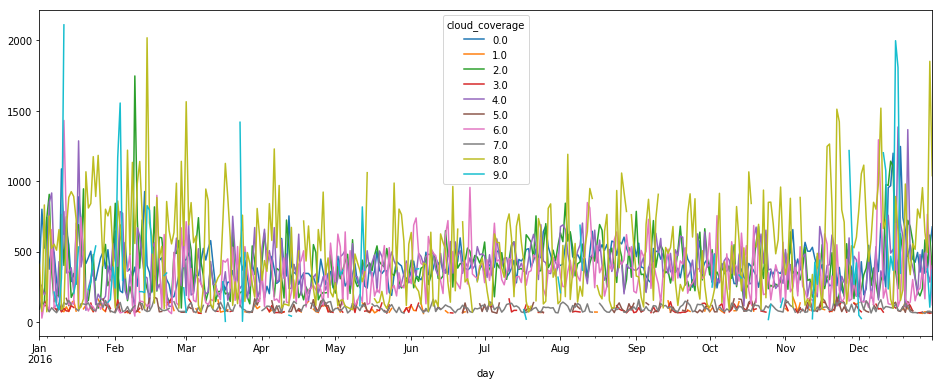

In [139]:
tidy_train.loc[:,['day','cloud_coverage','meter_reading']].pivot_table(values='meter_reading',index='day',columns='cloud_coverage',aggfunc=np.mean).plot(figsize = (16,6))

In [134]:
tidy_train.groupby('cloud_coverage').size()

cloud_coverage
0.0    5752501
1.0      25653
2.0    2431126
3.0      21866
4.0    1844497
5.0      18923
6.0     548557
7.0     125319
8.0     548105
9.0      74188
dtype: int64

### Dew temperature

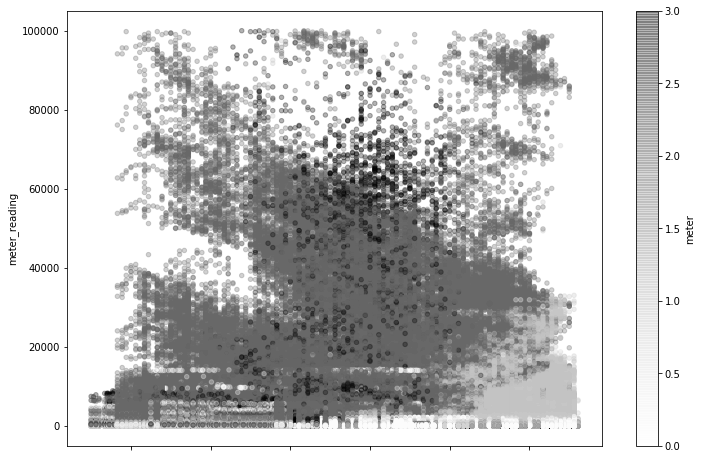

In [42]:
tidy_train.loc[:,['dew_temperature','meter_reading','meter']].plot.scatter(x = 'dew_temperature', y = 'meter_reading', c = 'meter',figsize = (12,8), alpha = 0.3)

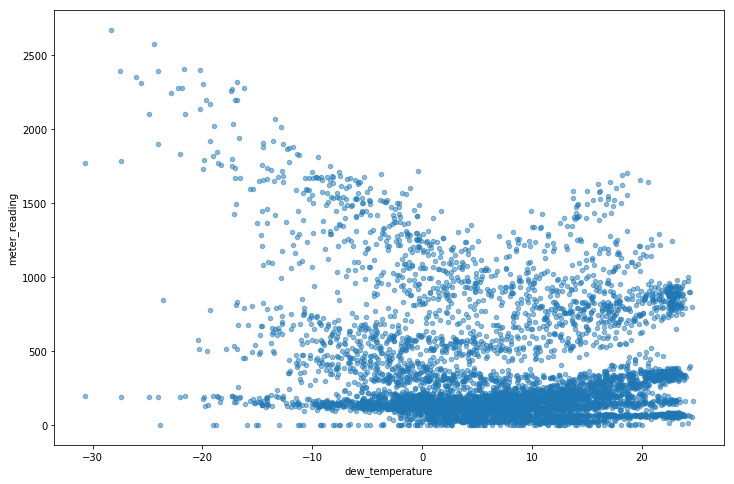

In [159]:
tidy_train.groupby(['day','site_id']).mean().plot.scatter(x = 'dew_temperature', y = 'meter_reading', figsize = (12,8), alpha=0.5)

Al igual que en la temperatura del aire, tiene una relación cuadrática con la variable dependiente

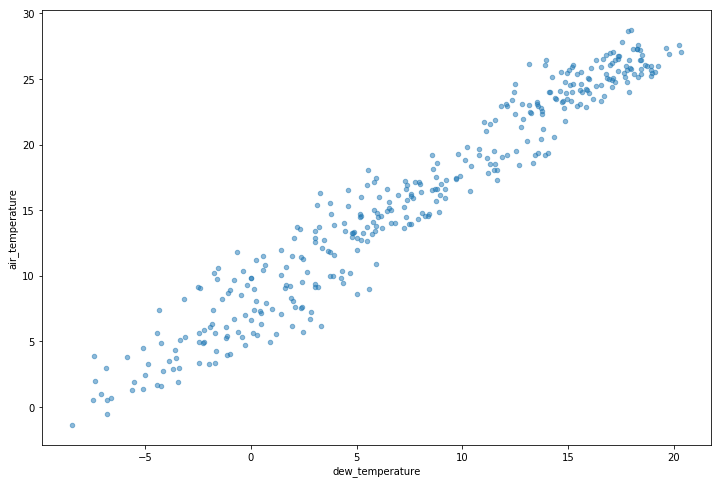

In [141]:
tidy_train.groupby('day').mean().plot.scatter(x = 'dew_temperature', y = 'air_temperature', figsize = (12,8), alpha=0.5)

Estas variables están muy relacionadas por lo que tal vez convenga eliminar una de ellas

### Precipitación

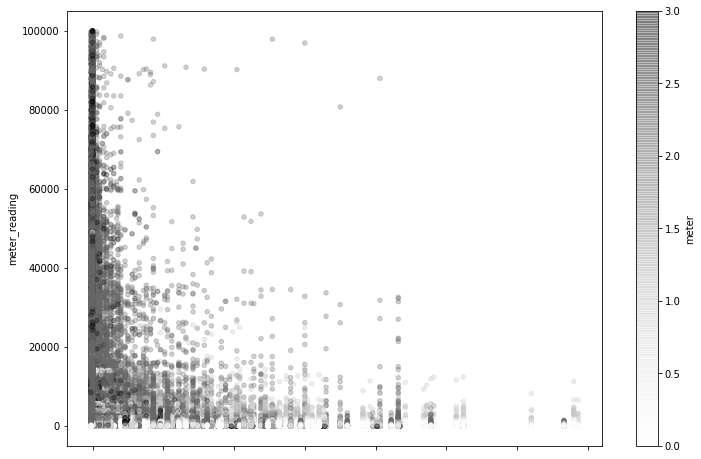

In [43]:
tidy_train.plot.scatter(x = 'precip_depth_1_hr', y = 'meter_reading',figsize = (12,8), alpha = 0.3)

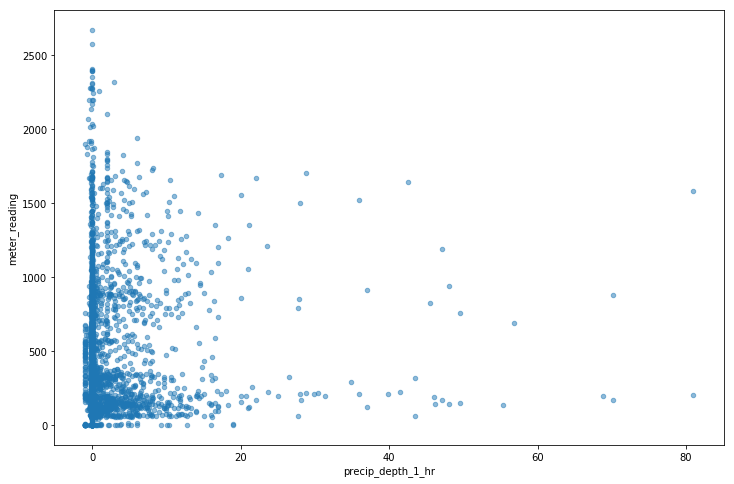

In [160]:
tidy_train.groupby(['day','site_id']).mean().plot.scatter(x = 'precip_depth_1_hr', y = 'meter_reading', figsize = (12,8), alpha=0.5)

Esta variable no parece aportar mucho

### Presión

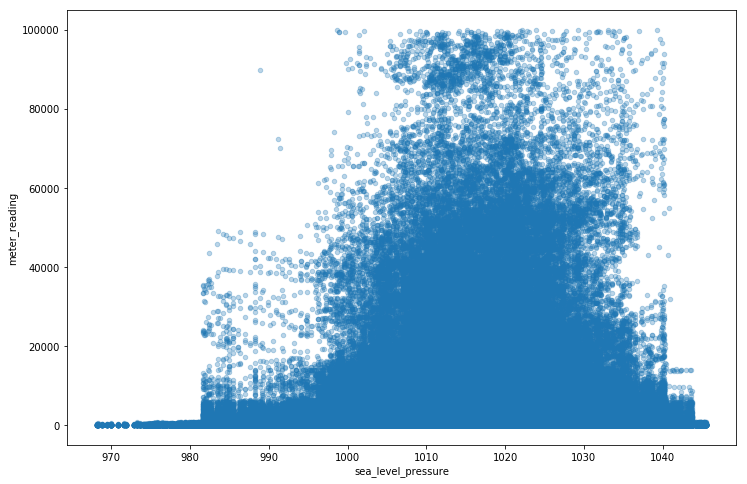

In [44]:
tidy_train.plot.scatter(x = 'sea_level_pressure', y = 'meter_reading',figsize = (12,8), alpha = 0.3)

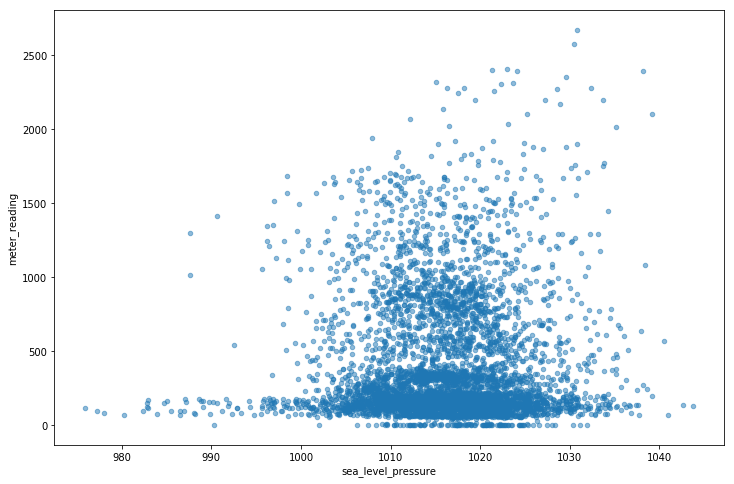

In [161]:
tidy_train.groupby(['day','site_id']).mean().plot.scatter(x = 'sea_level_pressure', y = 'meter_reading', figsize = (12,8), alpha=0.5)

### Wind direction

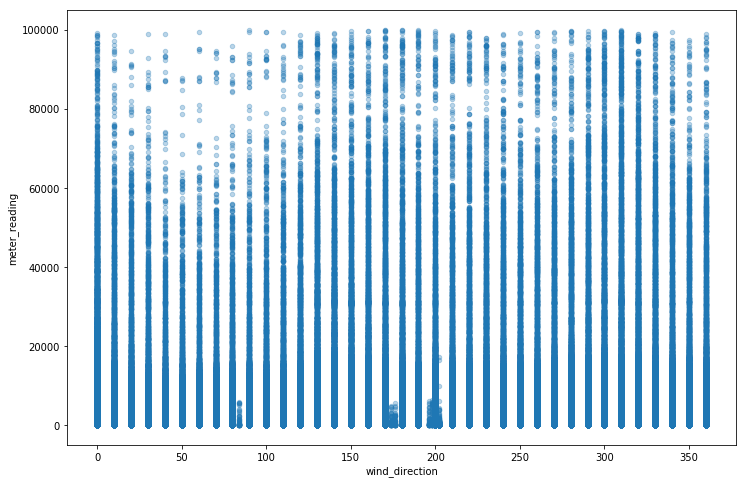

In [45]:
tidy_train.plot.scatter(x = 'wind_direction', y = 'meter_reading',figsize = (12,8), alpha = 0.3)

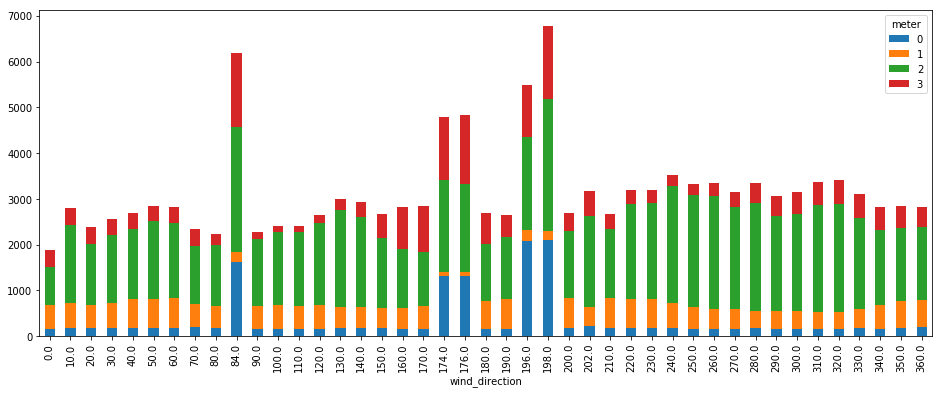

In [164]:
tidy_train.loc[:,['meter','wind_direction','meter_reading']].pivot_table(values='meter_reading',index='wind_direction',columns='meter',aggfunc=np.mean).plot.bar(stacked=True,figsize = (16,6))

### Wind speed

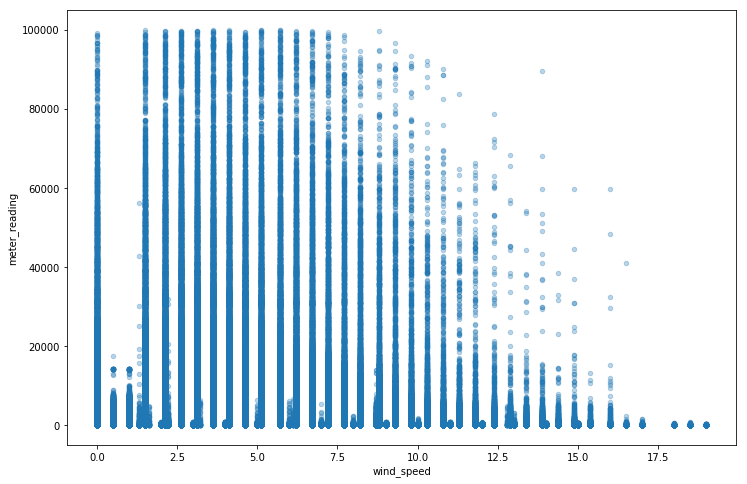

In [47]:
tidy_train.plot.scatter(x = 'wind_speed', y = 'meter_reading',figsize = (12,8), alpha = 0.3)

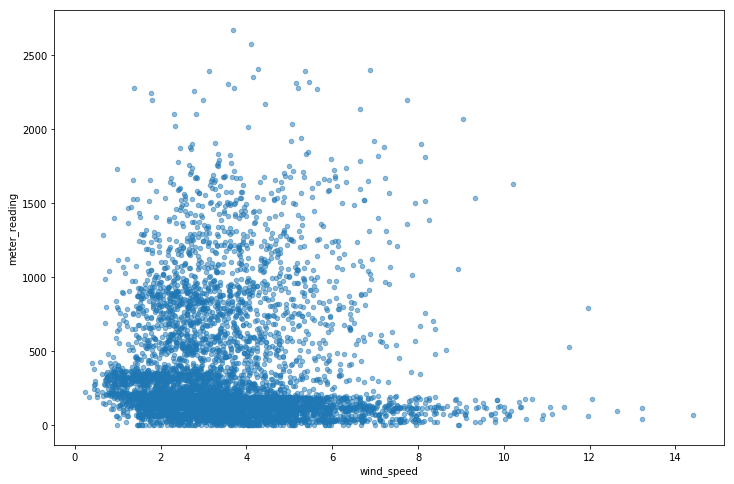

In [167]:
tidy_train.groupby(['day','site_id']).mean().plot.scatter(x = 'wind_speed', y = 'meter_reading', figsize = (12,8), alpha=0.5)